In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

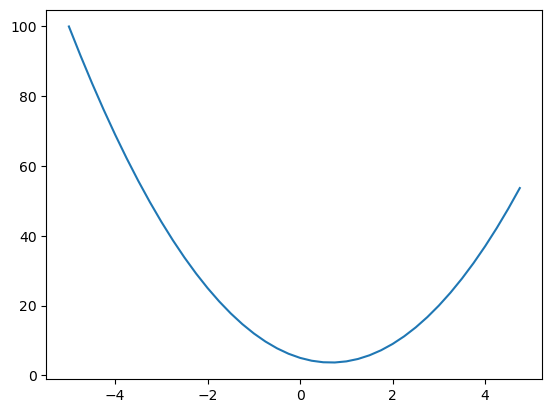

In [7]:
plt.plot(xs, ys)

In [8]:
def dx_df(x):
    return 6*x - 4

In [9]:
dys = dx_df(xs)
dys

array([-34. , -32.5, -31. , -29.5, -28. , -26.5, -25. , -23.5, -22. ,
       -20.5, -19. , -17.5, -16. , -14.5, -13. , -11.5, -10. ,  -8.5,
        -7. ,  -5.5,  -4. ,  -2.5,  -1. ,   0.5,   2. ,   3.5,   5. ,
         6.5,   8. ,   9.5,  11. ,  12.5,  14. ,  15.5,  17. ,  18.5,
        20. ,  21.5,  23. ,  24.5])

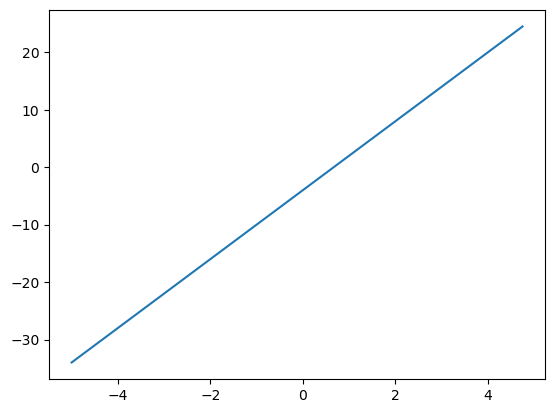

In [10]:
plt.plot(xs, dys)

$$L = {lim}_{h \rightarrow 0}\frac{f(x+h) - f(x)}{h}$$

In [11]:
h = 0.000001
x = -3.0
(f(x+h) - f(x)) / h

-21.999997002808414

In [12]:
# lets get more complex

h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a += h 
# b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [103]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to be able to process expressions as Value(3.0) + 1
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to be able to process expressions as Value(3.0) * 2
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self, ), ' tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




In [14]:
a = Value(2.0,  label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
# (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [15]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [16]:
d._op

'+'

In [17]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

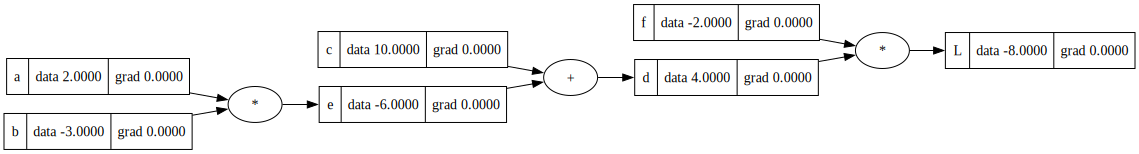

In [18]:
draw_dot(L)

In [19]:
# lets proof that dL/dL = 1

def lol():
    h = 0.001

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print(L2)
    print(L1)

    print((L2 - L1) / h)

lol()
        

-7.999
-8.0
1.000000000000334


In [20]:
L.grad = 1.0
f.grad = 4.0 # it's just d
d.grad = -2.0 # it's just f
e.grad = -2.0 # it's just d grad (we just "propagate" it)
c.grad = -2.0  # it's just d grad (we just "propagate" it)
a.grad = (-2.0 * -3.0) # e.grad * b
b.grad = (-2.0 * 2.0) # e.grad * a

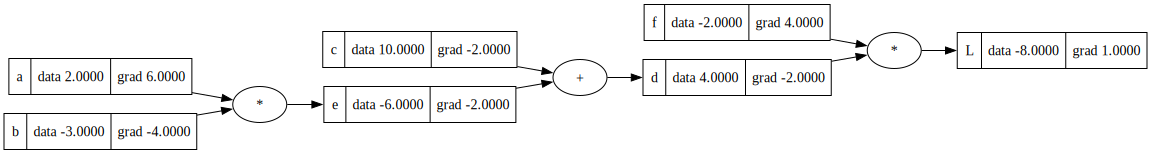

In [21]:
draw_dot(L)

L = d * f

dL/dd =? f

(f(x+h) - f(x))/h

((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h
(h*f)/h
f

In [22]:
# just adding h to different variables and see how it's affect L (and what is a derivative of L regarding to this variable)

def lol():
    h = 0.001

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0,  label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print(L2)
    print(L1)

    print((L2 - L1) / h)

lol()

-8.001999999999999
-8.0
-1.9999999999988916


dd / dc ? 1.0
dd / de ? 1.0

d = c + e

WANT:
dL / dc

KNOW:
dL / dd
dd / dc

CHAIN RULE:

dL / dc = (dL / dd) * (dd / dc)

(f(x+h) - f(x))/h

(c+h + e) - (c+e))/h
(c+h+e-c-e)/h
h/h
1.0

dl / de = -2.0

e = a * b
de / da =? b

dL / da = (dL / de) * (de / da)

# Let's backpropagate through a neuron

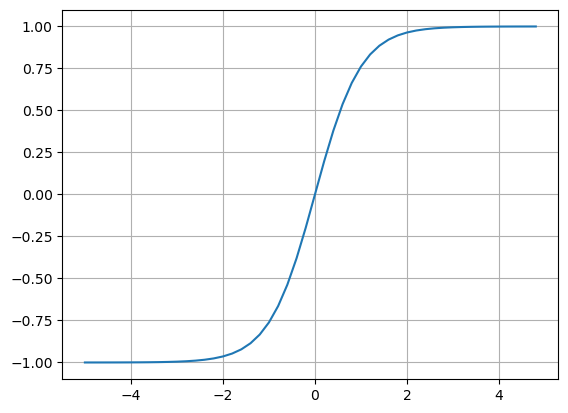

In [23]:
# Activation function

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [40]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 =x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

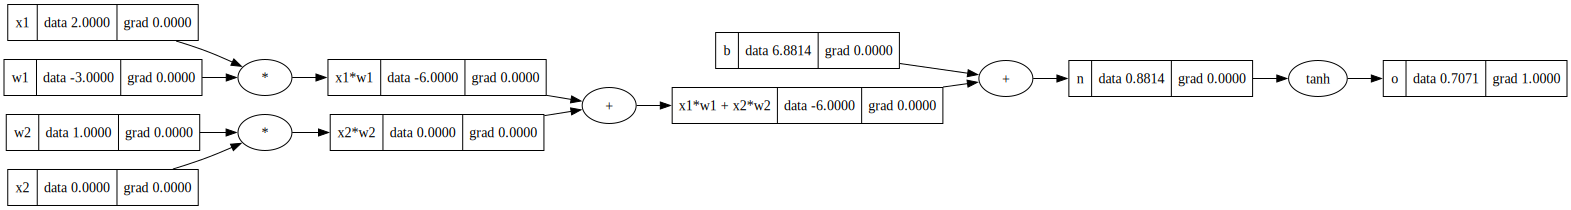

In [43]:
draw_dot(o)

In [42]:
o.grad = 1.0

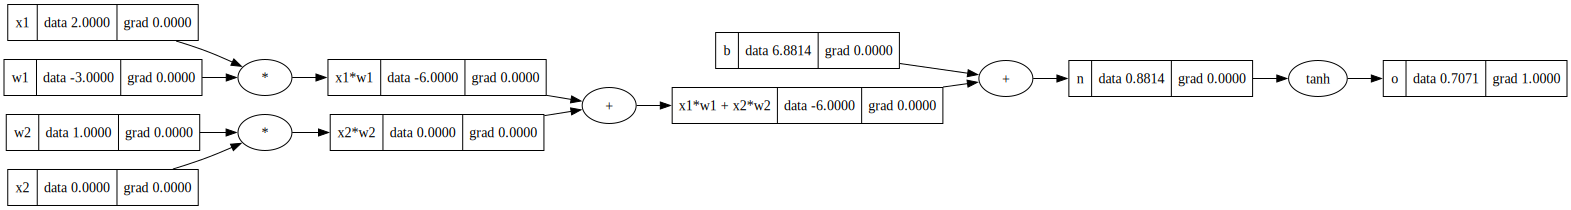

In [44]:
draw_dot(o)

In [45]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2

1 - o.data**2

0.4999999999999999

In [46]:
n.grad = 0.5 # (1 - o.data**2)

In [47]:
x1w1x2w2.grad = 0.5 # just distribute it
b.grad = 0.5

In [48]:
x1w1.grad = 0.5 # just distribute it
x2w2.grad = 0.5

In [49]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

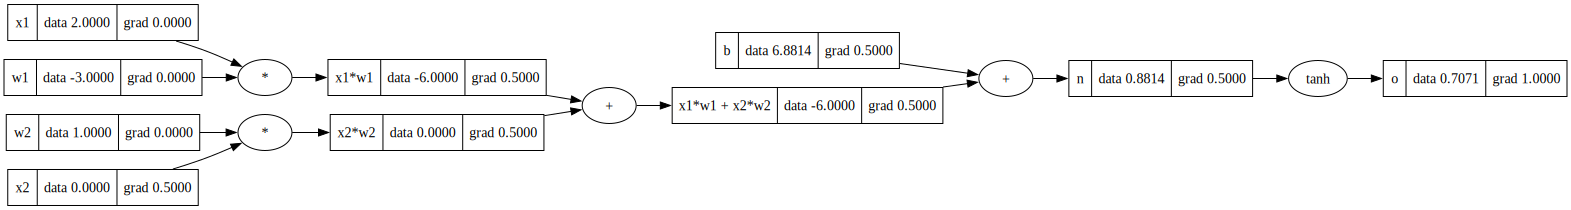

In [50]:
draw_dot(o)

In [51]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

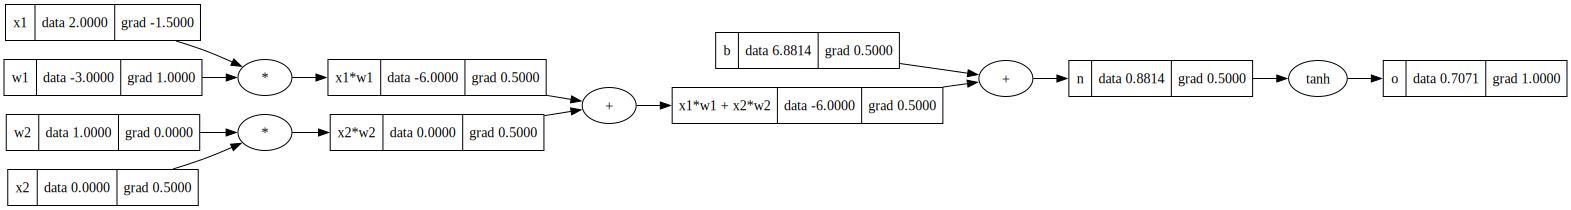

In [52]:
draw_dot(o)

# Let's automate backpropagation

In [54]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 =x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [57]:
o.grad = 1.0
o._backward()

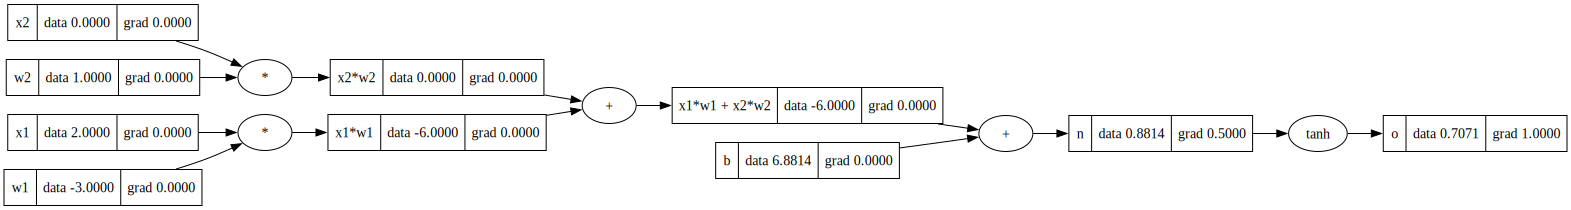

In [58]:
draw_dot(o)

In [59]:
n._backward()

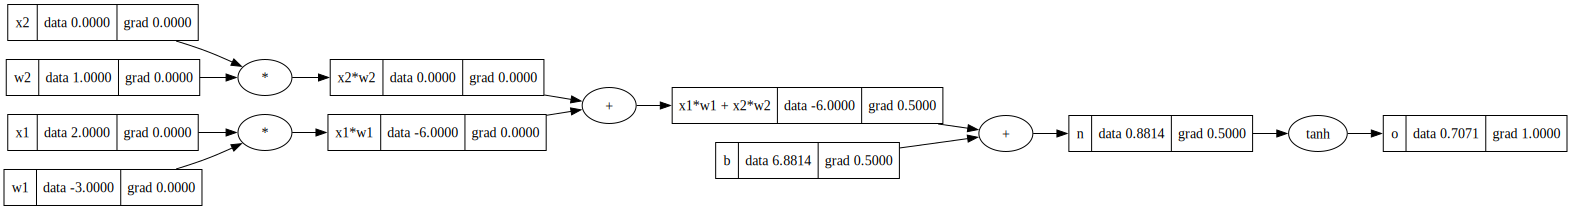

In [60]:
draw_dot(o)

In [61]:
x1w1x2w2._backward() 

In [62]:
x1w1._backward()
x2w2._backward()

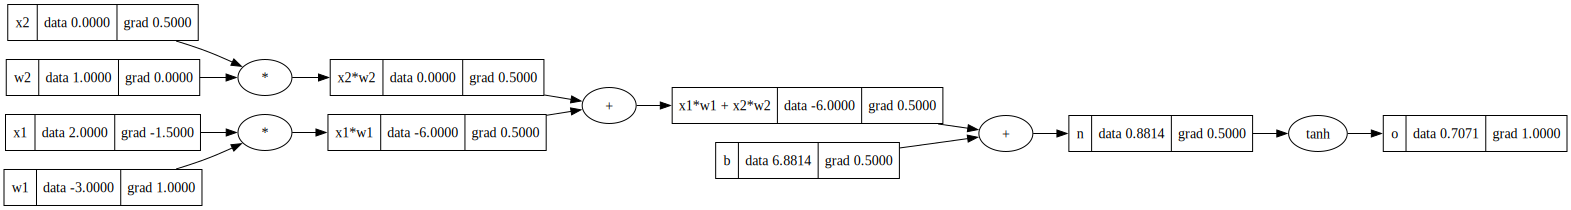

In [63]:
draw_dot(o)

In [64]:
# we can automate this _backward() calls with topological sort

# topological sort is a way to layout a graph so all edges go from left to right (or otherwise)

In [65]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [66]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

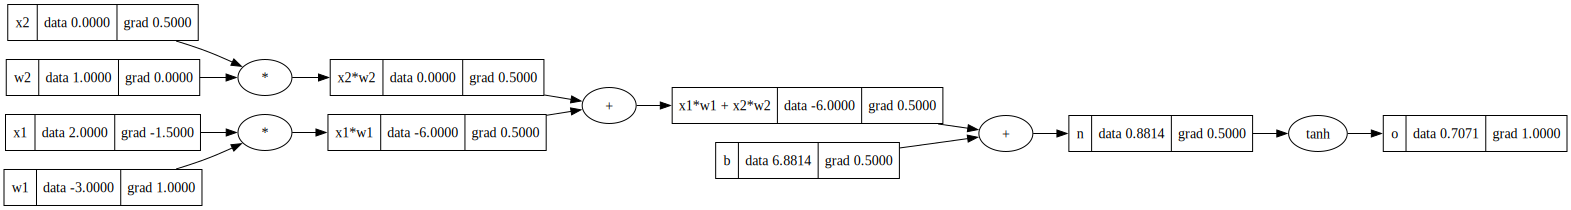

In [67]:
draw_dot(o)

# Let's hide topo sort logic inside the Value class (see the cell with the Value class defeinition)

In [73]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 =x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [74]:
o.backward()

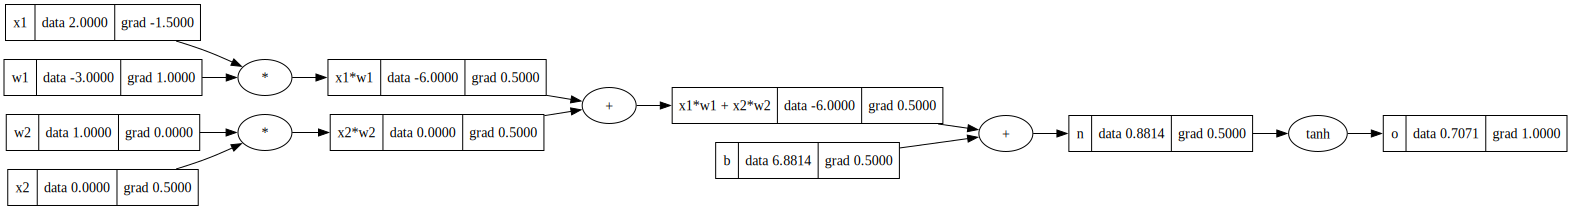

In [75]:
draw_dot(o)

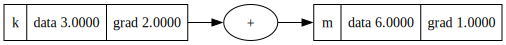

In [77]:
k = Value(3.0, label='k')
m = k + k; m.label = 'm'
m.backward()
draw_dot(m)

In [80]:
k = Value(2.0)
m = Value(4.0)

k / m

Value(data=0.5)

# Let's break out tanh function to multiple more simple operations

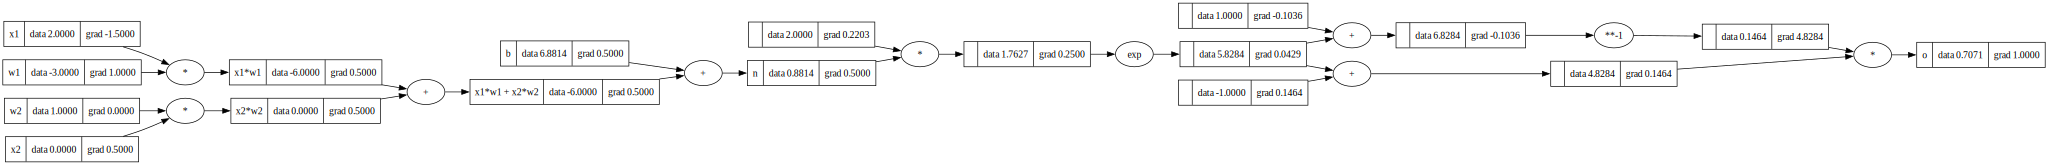

In [86]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 =x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()

draw_dot(o)

# Let's use pytorch

In [88]:
import torch

In [90]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

In [91]:
o.data.item()

0.7071066904050358

In [92]:
o.backward()

In [93]:
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Let's build own Neural Network

In [138]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # the second arguemnt is the start value for sum func
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [139]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9325356577559885)

In [140]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=-0.7785760666905326),
 Value(data=0.48947930684508095),
 Value(data=0.9995730901589318)]

In [141]:
# Let's create MLP with the following structure: Input Layer (3-dim), Hidden Layern 1 (4-dim), Hidden Layer 2 (4-dim), Output Layer (1-dim)

x = [2.0, 3.0, -1.0]

mlp = MLP(3, [4, 4, 1])
mlp(x) # this is a forward-pass of MLP

Value(data=0.9465202512463368)

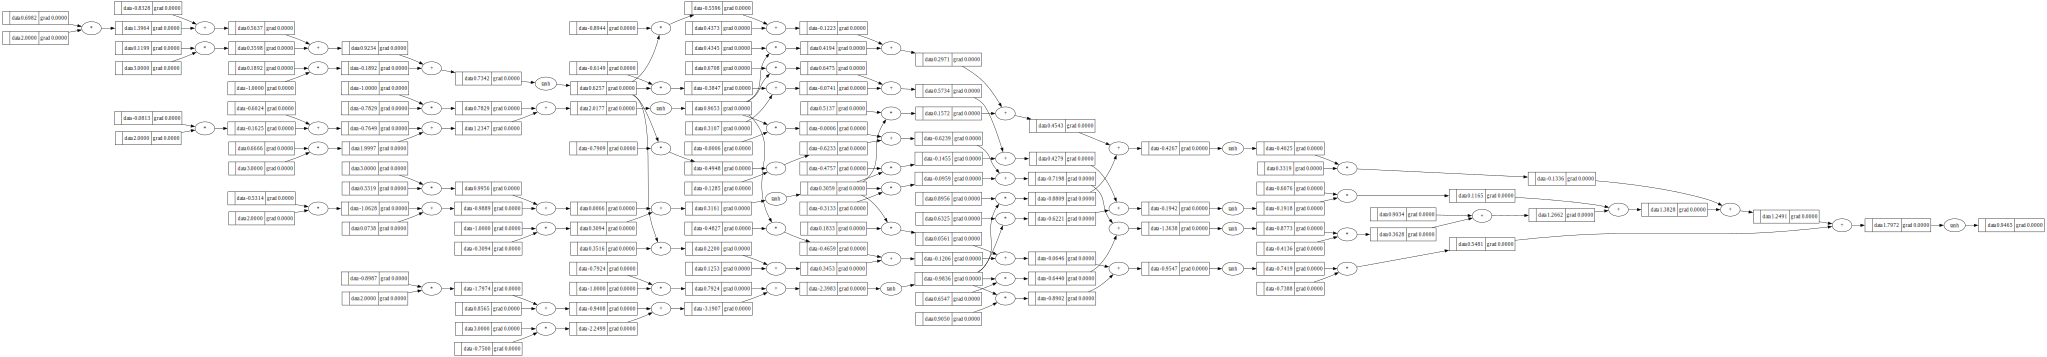

In [142]:
draw_dot(mlp(x))

# Let's create a simple dataset and write a loss function

In [143]:
xs = [
    [2.0, 3.0, -1.0], # example 1
    [3.0, -1.0, 0.5], # example 2
    [0.5, 1.0, 1.0],  # example 3
    [1.0, 1.0, -1.0], # example 4
] # features

ys = [1.0, -1.0, -1.0, 1.0] # targets
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.9465202512463368),
 Value(data=0.8946526433886526),
 Value(data=0.8980870902799372),
 Value(data=0.7311330802666687)]

In [144]:
# loss is a single value that shows us how well the neural network is performing

# this is MSE

loss = sum((y_out - y_ground_truth)**2 for y_ground_truth, y_out in zip(ys, ypred))

In [145]:
loss

Value(data=7.267592745440611)

In [134]:
loss.backward()

In [135]:
# now our values have grads

mlp.layers[0].neurons[0].w[0].grad

-1.2702324447409068

In [137]:
# draw_dot(loss)

In [146]:
mlp.parameters()

[Value(data=0.6982123624132199),
 Value(data=0.1199230085256382),
 Value(data=0.1891870428896658),
 Value(data=-0.8327701158173517),
 Value(data=-0.08126643114415111),
 Value(data=0.6665505112303336),
 Value(data=-0.7829371415589981),
 Value(data=-0.6023715060631769),
 Value(data=-0.531386878448481),
 Value(data=0.33185658140703),
 Value(data=-0.3094158072922528),
 Value(data=0.07384026801108057),
 Value(data=-0.8986868755219348),
 Value(data=-0.749956389172485),
 Value(data=-0.7924314677906099),
 Value(data=0.8565461310551201),
 Value(data=-0.7908509662511829),
 Value(data=-0.0005995599869543788),
 Value(data=-0.3133367126439872),
 Value(data=0.6547298496585712),
 Value(data=-0.12852532870824707),
 Value(data=-0.614946960039632),
 Value(data=0.6708227876319248),
 Value(data=-0.47571215269975786),
 Value(data=0.6324709962290995),
 Value(data=0.31065034103448674),
 Value(data=-0.8943794380065868),
 Value(data=0.4344959060635909),
 Value(data=0.5137296062719436),
 Value(data=0.8956188698

In [147]:
loss.backward()

In [150]:
mlp.layers[0].neurons[0].w[0].grad

0.006529649386382147

In [151]:
mlp.layers[0].neurons[0].w[0].data

0.6982123624132199

In [152]:
for p in mlp.parameters():
    p.data += 0.01 * -p.grad

In [153]:
mlp.layers[0].neurons[0].w[0].data

0.6981470659193562

In [174]:
# Let's run this 2 cells multiple times and see how our loss will get minimized

loss.backward()
for p in mlp.parameters():
    p.data += 0.01 * -p.grad

In [175]:
ypred = [mlp(x) for x in xs]
loss = sum((y_out - y_ground_truth)**2 for y_ground_truth, y_out in zip(ys, ypred))
loss

Value(data=0.008577848803381624)